In [1]:
%matplotlib inline

from pathlib import Path
from drone_detector.tiling import *
import os, sys
import geopandas as gpd

# Make data

In [2]:
tile_folder = Path('../data/hiidenportti/raw/plot_patches/')
vector_folder = Path('../data/hiidenportti/raw/vector_plots/')

outpath = Path('../data/hiidenportti/processed_unet/')

if not os.path.exists(outpath): os.makedirs(outpath)

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('shp')]
assert len(tiles) == len(vectors)

In [3]:
import rasterio as rio

In [ ]:
for t in tiles:
    with rio.open(tile_folder/t) as f:
        im = f.read()
        tilesize = min(im.shape[1], im.shape[2])/8
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = f'{t.split("_")[0]}.shp'
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname)
    for patch in (f'{tiler.vector_path}/{f}' for f in os.listdir(tiler.vector_path) if f.endswith('geojson')):
        gdf = gpd.read_file(patch)
        gdf['geometry'] = gdf.geometry.buffer(0.05)
        gdf.to_file(patch)
    tiler.tile_and_rasterize_vector('groundwood')

# Train model

In [4]:
from fastai.vision.all import *
from drone_detector.visualizations import *
from drone_detector.data import *

def label_func(fn): 
    return str(fn).replace('raster_tiles', 'rasterized_vector_tiles')
    #return f'{outpath}/rasterized_vector_tiles/{fn.stem}{fn.suffix}'

fnames = [Path(f'{outpath}/{tile}/raster_tiles/{f}') 
          for tile in [til for til in os.listdir(outpath) if os.path.isdir(outpath/til)]
          for f in os.listdir(outpath/tile/'rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   codes=['Standing', 'Fallen'],
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   item_tfms=[Resize(256)],
                                                   batch_tfms= [
                                                       *aug_transforms(size=224),
                                                       Normalize.from_stats(*imagenet_stats)
                                                   ])

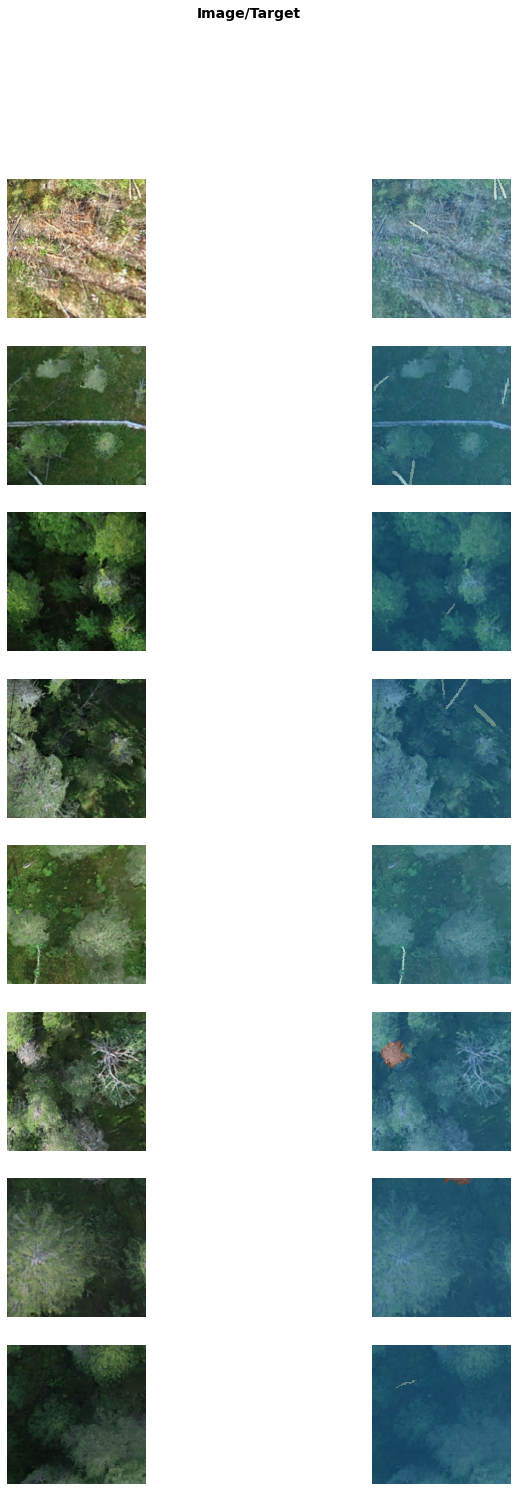

In [5]:
deadwood.show_batch(max_n=16)

In [6]:
from drone_detector.losses import LovaszSoftmaxLossFlat, DiceLoss, FocalDice
from drone_detector.metrics import JaccardCoeffMulti

learn = unet_learner(deadwood, resnet50, pretrained=True, n_in=3, n_out=3,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=FocalDice()
                    ).to_fp16()

Because of [this](https://github.com/fastai/fastai/issues/3130) do the following.

In [13]:
#for o in Tensor.__getitem__,:
#    TensorBase.register_func(o, TensorMask, TensorImageBase)
#    TensorBase.register_func(o, TensorImageBase, TensorMask)

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=2.75422871709452e-06)

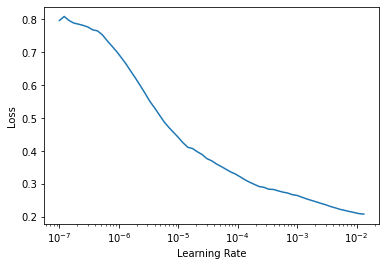

In [7]:
learn.lr_find()

In [8]:
learn.fine_tune(5, freeze_epochs=1, base_lr=1e-3)

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.059426,0.036111,0.706716,0.590846,01:26


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff_multi,time
0,0.032882,0.030574,0.683846,0.570843,01:26
1,0.032307,0.026679,0.763238,0.650836,01:29
2,0.026503,0.025546,0.703515,0.588149,01:29
3,0.023060,0.023056,0.765002,0.651252,01:33
4,0.021003,0.022652,0.783461,0.672377,01:35


In [10]:
learn.to_fp32()

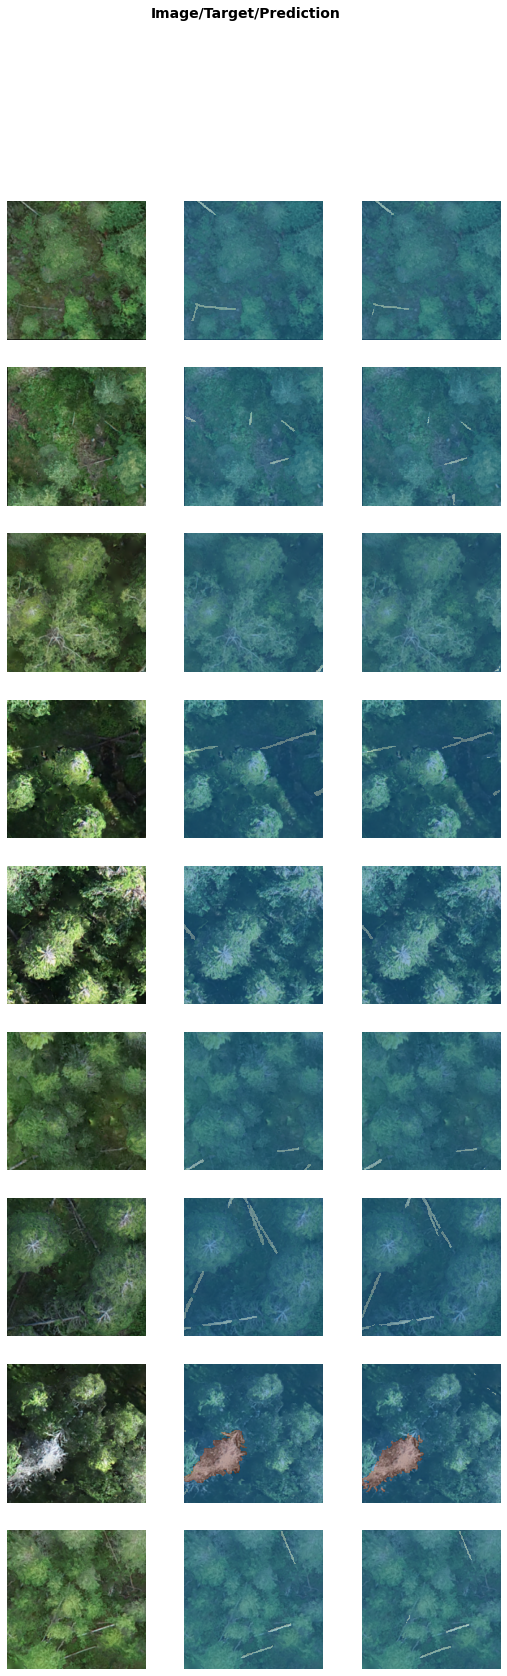

In [15]:
learn.show_results()

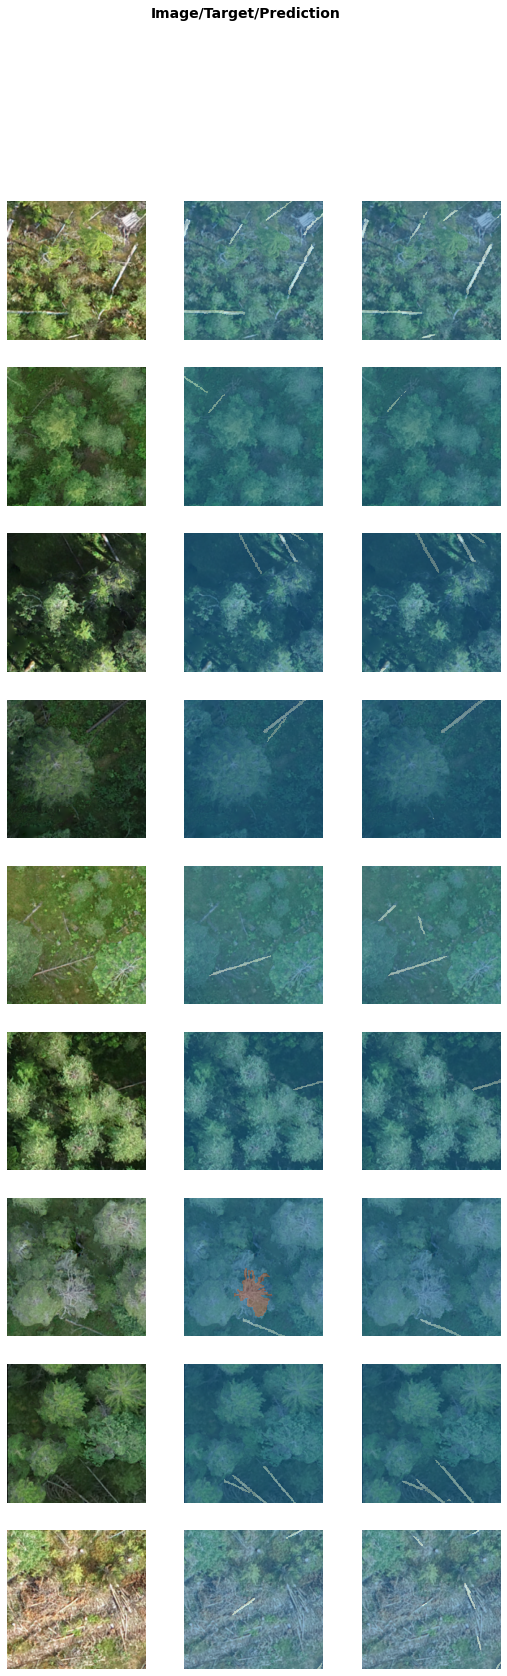

In [14]:
learn.show_results()

In [12]:
learn.export('unet_hiidenportti_lovasz.pkl')

# Test with holdout

In [21]:
from drone_detector.predict import predict_segmentation

In [22]:
test_rasters = [f'../data/hiidenportti/raw/test_plot_patches/{f}' 
                for f in os.listdir('../data/hiidenportti/raw/test_plot_patches') if f.endswith('tif')]

In [27]:
os.makedirs('../data/hiidenportti/results/unet')

In [84]:
from tqdm import tqdm
from osgeo import gdal
from shutil import rmtree

In [115]:
def predict_segmentation_test(path_to_model:Param("Path to pretrained model file",type=str)=None,
                         path_to_image:Param("Path to image to annotate", type=str)=None,
                         outfile:Param('Path and filename for output raster', type=str)=None,
                         processing_dir:Param("Directory to save the intermediate tiles. Deleted after use", type=str)='temp',
                         tile_size:Param("Tile size to use. Default 400x400px tiles", type=int)=400,
                         tile_overlap:Param("Tile overlap to use. Default 100px", type=int)=100
    ):
    """Segment image into land cover classes with a pretrained models
    TODO save also information about label and class
    TODO add test-time augmentations"""
    if os.path.exists(processing_dir): 
        print('Processing folder exists')
        return
    os.makedirs(processing_dir)
    print(f'Reading and tiling {path_to_image} to {tile_size}x{tile_size} tiles with overlap of {tile_overlap}px')
    tiler = Tiler(outpath=processing_dir, gridsize_x=int(tile_size), gridsize_y=int(tile_size), 
                  overlap=(int(tile_overlap), int(tile_overlap)))
    tiler.tile_raster(path_to_image)
    
    # Check whether is possible to use gpu
    cpu = True if not torch.cuda.is_available() else False

    # Loading pretrained model
    
    # PyTorch state dict TODO
    if path_to_model.endswith('.pth') or path_to_model.endswith('.pt'):
        print('Using PyTorch state dict not yet supported')
        print('Removing intermediate files')
        rmtree(processing_dir)
        return
    # fastai learn.export()
    elif path_to_model.endswith('.pkl'):
        learn = load_learner(path_to_model, cpu=cpu)
        test_files = get_image_files(f'{processing_dir}/raster_tiles')
        print('Starting prediction')
        os.makedirs(f'{processing_dir}/predicted_rasters')
        for chunk in range(0, len(test_files), 300):
            test_dl = learn.dls.test_dl(test_files[chunk:chunk+300], num_workers=0, bs=1)
            preds = learn.get_preds(dl=test_dl, with_input=False, with_decoded=False)[0]

            print('Rasterizing predictions')
            for f, p in tqdm(zip(test_files[chunk:chunk+300], preds)):
                #if len(p.shape) == 3: p = p[0]
                ds = gdal.Open(str(f))
                out_raster = gdal.GetDriverByName('gtiff').Create(f'{processing_dir}/predicted_rasters/{f.stem}.{f.suffix}',
                                                                  ds.RasterXSize,
                                                                  ds.RasterYSize,
                                                                  p.shape[0], gdal.GDT_Int16)
                out_raster.SetProjection(ds.GetProjectionRef())
                out_raster.SetGeoTransform(ds.GetGeoTransform())
                np_pred = p.numpy()#.argmax(axis=0)
                np_pred = np_pred.round(2)
                np_pred *= 100
                np_pred = np_pred.astype(np.int16)
                for c in range(p.shape[0]): 
                    band = out_raster.GetRasterBand(c+1).WriteArray(np_pred[c])
                    band = None
                #band = out_raster.GetRasterBand(1).WriteArray(np_pred)
                out_raster = None
                ds = None
            
    print('Merging predictions')
    temp_full = f'{processing_dir}/full_raster.tif'
    untile_raster(f'{processing_dir}/predicted_rasters', outfile=temp_full, method='sum')
    
    print('Postprocessing predictions')
    
    raw_raster = gdal.Open(temp_full)
    processed_raster = gdal.GetDriverByName('gtiff').Create(outfile,
                                                            raw_raster.RasterXSize,
                                                            raw_raster.RasterYSize,
                                                            1, gdal.GDT_Int16)
    processed_raster.SetProjection(raw_raster.GetProjectionRef())
    processed_raster.SetGeoTransform(raw_raster.GetGeoTransform())
    raw_np = raw_raster.ReadAsArray()
    pred_np = raw_np.argmax(axis=0)
    band = processed_raster.GetRasterBand(1).WriteArray(pred_np)
    raw_raster = None
    band = None
    processed_raster = None
    
    print('Removing intermediate files')
    rmtree(processing_dir)
    return

In [119]:
FocalLossFlat.activation

<function fastai.losses.CrossEntropyLossFlat.activation(self, x)>

In [116]:
for t in test_rasters:
    outfile_name = f'../data/hiidenportti/results/unet/{t.split("/")[-1]}'
    predict_segmentation_test('../data/analysis_data/unet_hiidenportti.pkl', t, outfile_name, tile_size=224, tile_overlap=40)

Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1053_Hiidenportti_Chunk9_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


<ipython-input-9-d1b84da2541d>:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_jaccard_scores)


Rasterizing predictions


121it [00:00, 231.80it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/10_Hiidenportti_Chunk4_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 225.41it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1035_Hiidenportti_Chunk5_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 217.95it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1025_Hiidenportti_Chunk5_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 235.70it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/109_Hiidenportti_Chunk5_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 219.90it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1047_Hiidenportti_Chunk4_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 222.93it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/11_Hiidenportti_Chunk4_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 210.50it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/114_Hiidenportti_Chunk5_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 216.98it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1038_Hiidenportti_Chunk7_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


121it [00:00, 219.99it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
Reading and tiling ../data/hiidenportti/raw/test_plot_patches/1033_Hiidenportti_Chunk3_orto.tif to 224x224 tiles with overlap of 40px


0it [00:00, ?it/s]

Starting prediction


Rasterizing predictions


144it [00:00, 214.54it/s]


Merging predictions
Postprocessing predictions
Removing intermediate files
